<a href="https://colab.research.google.com/github/kalyankargouri/computer-vision/blob/main/Face_and_Pose_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 17 images in your Drive folder.
No face detected in chessboard1.png
No face detected in chess2.jpg
No face detected in chess3.jpg
No face detected in chess4.jpg
No face detected in chess5.jpg
No face detected in chess6.jpg
No face detected in chess7.jpg
No face detected in chess8.jpg
No face detected in chess9.png
No face detected in chess10.jpg
No face detected in tajmahal1.jpg
No face detected in tajmahal.jpg
Error loading image: /content/drive/MyDrive/imagesclg/road.jpg
No face detected in frontview.jpg
No face detected in sideview.jpg
No face detected in traffic.jpeg


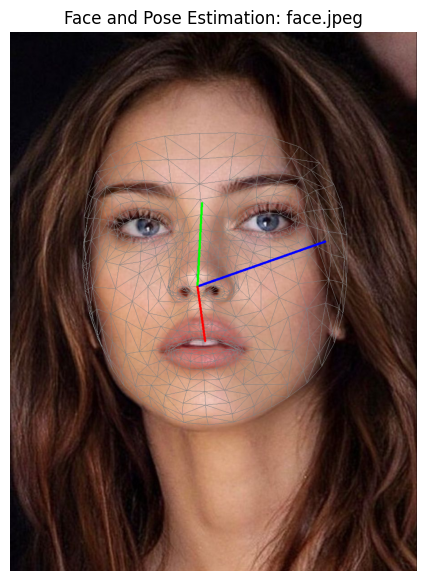

In [1]:
#Face and Pose Recognition
!pip install mediapipe opencv-python
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
import os

# Correct the path to your Drive image folder
# Ensure the path points to the folder containing the images
drive_image_folder = '/content/drive/MyDrive/imagesclg'

# List image files in this folder
image_files = [os.path.join(drive_image_folder, f) for f in os.listdir(drive_image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print(f"Found {len(image_files)} images in your Drive folder.")

# Initialize MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

# Function to estimate head pose (as before)
def estimate_head_pose(landmarks, image_shape):
    import numpy as np
    # Select specific landmarks for head pose estimation
    image_points = np.array([
        landmarks[1],   # Nose tip
        landmarks[33],  # Left eye corner
        landmarks[263], # Right eye corner
        landmarks[61],  # Left mouth corner
        landmarks[291], # Right mouth corner
        landmarks[0]    # Chin
    ], dtype='double')

    model_points = np.array([
        (0.0, 0.0, 0.0),
        (-30.0, -65.5, -5.0),
        (30.0, -65.5, -5.0),
        (-40.0, -105.0, -5.0),
        (40.0, -105.0, -5.0),
        (0.0, -133.0, -5.0)
    ])

    # Correct calculation of camera matrix
    focal_length = image_shape[1]
    center = (image_shape[1] / 2, image_shape[0] / 2)
    camera_matrix = np.array([
        [focal_length, 0, center[0]],
        [0, focal_length, center[1]],
        [0, 0, 1]
    ], dtype='double')

    dist_coeffs = np.zeros((4, 1))

    success, rotation_vector, translation_vector = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs)

    return rotation_vector, translation_vector, camera_matrix, dist_coeffs

# Process each image from your Drive folder
for file_path in image_files:
    image = cv2.imread(file_path)
    if image is None:
        print(f"Error loading image: {file_path}")
        continue

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = face_mesh.process(image_rgb)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            landmarks_2d = []
            for lm in face_landmarks.landmark:
                # Correct landmark coordinate extraction
                x, y = int(lm.x * image_rgb.shape[1]), int(lm.y * image_rgb.shape[0])
                landmarks_2d.append((x, y))

            # Ensure there are enough landmarks before proceeding
            if len(landmarks_2d) < 292: # Assuming 292 is the minimum required for selected points
                print(f"Not enough landmarks detected in {os.path.basename(file_path)}")
                continue


            r_vec, t_vec, cam_mtx, dist = estimate_head_pose(landmarks_2d, image_rgb.shape)

            annotated_image = image_rgb.copy()
            mp_drawing.draw_landmarks(
                image=annotated_image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())

            # Correct axis points for drawing
            axis_points_3d = np.float32([
                [100, 0, 0],  # X-axis
                [0, 100, 0],  # Y-axis
                [0, 0, 100]   # Z-axis
            ]).reshape(-1, 3)


            imgpts, _ = cv2.projectPoints(axis_points_3d, r_vec, t_vec, cam_mtx, dist)

            # Ensure nose_tip is a tuple
            nose_tip = landmarks_2d[1] # Assuming landmark 1 is the nose tip
            imgpts = np.int32(imgpts).reshape(-1, 2)


            # Draw axis lines
            cv2.line(annotated_image, nose_tip, tuple(imgpts[0]), (0,0,255), 3) # X-axis (Red)
            cv2.line(annotated_image, nose_tip, tuple(imgpts[1]), (0,255,0), 3) # Y-axis (Green)
            cv2.line(annotated_image, nose_tip, tuple(imgpts[2]), (255,0,0), 3) # Z-axis (Blue)


            plt.figure(figsize=(10,7))
            plt.imshow(annotated_image)
            plt.title(f"Face and Pose Estimation: {os.path.basename(file_path)}")
            plt.axis('off')
            plt.show()
    else:
        print(f"No face detected in {os.path.basename(file_path)}")